In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

plt.style.use('./mystyle.mplstyle')

def get_columns(df):
    loc_cols = [col for col in df if 'loc' in col]
    wcols = [col for col in df if 'd' not in col and 'w' in col and not 'west' in col]
    dcols = [col for col in df if 'w' not in col and 'd' in col]
    wd_cols = [col for col in df if 'dw' in col]
    east_cols = [col for col in df if 'east' in col]
    west_cols = [col for col in df if 'west' in col]

    w = df[wcols]
    d = df[dcols]
    dw = df[wd_cols]
    loc = df[loc_cols]
    west = df[west_cols]
    east = df[east_cols]
    nob = df['no_breach']
    return w, d, loc, dw, nob, east, west

def calc_perc(df, min_per=.05, max_per=.95):
    # Calculate the mean, 5th, and 95th percentiles
    mean_values = df.mean(axis=1)
    percentile_5 = df.quantile(min_per, axis=1)
    percentile_95 = df.quantile(max_per, axis=1)
    return mean_values, percentile_5, percentile_95

import pandas as pd
import os

# def get_columns(df):
#     loc_cols = [col for col in df if 'loc' in col]
#     wcols = [col for col in df if 'd' not in col and 'w' in col]
#     dcols = [col for col in df if 'w' not in col and 'd' in col]
#     wd_cols = [col for col in df if 'dw' in col]
#
#     w = df[wcols]
#     d = df[dcols]
#     dw = df[wd_cols]
#     loc = df[loc_cols]
#     nob = df['no_breach']
#     return w, d, loc, dw, nob

def calc_perc(df, min_per=0.05, max_per=0.95):
    # Calculate the mean, 5th, and 95th percentiles
    mean_values = df.mean(axis=1)
    med_values = df.median(axis=1)
    percentile_5 = df.quantile(min_per, axis=1)
    percentile_95 = df.quantile(max_per, axis=1)
    return mean_values, med_values, percentile_5, percentile_95


from matplotlib.ticker import FormatStrFormatter

def gauge_data_plotting(data):
    # Define the grid size
    num_rows = 3
    num_cols = 2

    # Create a figure and axes for the subplots
    fig = plt.figure(constrained_layout=True, figsize=(7, 7))
    subfigs = fig.subfigures(nrows=num_rows, ncols=1)
    letters = ['a', 'b', 'c', 'd', 'e', 'f']
    for i, (loc, loc_data) in enumerate(data.items()):
        axs = subfigs[i].subplots(nrows=1, ncols=2)
        mid = (fig.subplotpars.right + fig.subplotpars.left) / 2
        subfigs[i].suptitle(f'{loc.capitalize()}', x=mid)

        # Iterate over the gauge numbers and plot each category's data
        for j, (n, gauge_data) in enumerate(loc_data.items()):
            ax = axs[j]
            for category, category_data in gauge_data['data'].items():
                if category_data['name'] == 'No breach':
                    ax.plot(category_data['data'].index, category_data['data'],
                            label=category_data['name'], color=category_data['color'], linestyle='--')
                else:
                    mean, medi, minp, maxp = calc_perc(category_data['data'])
                    ax.plot(category_data['data'].index, mean, color=category_data['color'], label=category_data['name'])
                    ax.plot(category_data['data'].index, medi, color=category_data['color'], linestyle='--')
                    ax.fill_between(category_data['data'].index, minp, maxp, color=category_data['color'], alpha=0.3,
                                    rasterized=True)
            ax.set_title(f'Gauge {letters[i * 2 + j]}')
            ax.set_xlim(-2, 4)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
            ax.xaxis.get_major_formatter()._usetex = False
            ax.yaxis.get_major_formatter()._usetex = False
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            # ax.tick_params(axis='both', which='major', labelsize=12, font='Times New Roman')

            if i == 2:
                ax.set_xlabel('Hours from landfall')
            if j == 0:
                ax.set_ylabel('Surge height (m)')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center',
               bbox_to_anchor=(0, -0.1, 1, 0.25), ncol=5, fontsize=12)
    plt.savefig('/home/catherinej/Downloads/fig4.pdf', bbox_inches='tight')
    plt.show()

def simple_gauge_plotting():
    sandy_hook = pd.read_csv('../code/plotting/CO-OPS_8531680_met.csv',
                             parse_dates=[['Date', 'Time (GMT)']])
    sandy_hook['storm'] = sandy_hook['Verified (m)'] - sandy_hook['Predicted (m)']
    sandy_hook['Date_Time (GMT)'] = pd.to_datetime(sandy_hook['Date_Time (GMT)'])
    sandy_hook['Seconds'] = ((sandy_hook['Date_Time (GMT)'] - datetime.datetime(1938, 9, 21, 19, 20,
                                                                                00)).dt.total_seconds()) / 3600.
    sandy_hook[sandy_hook['Seconds'] >= -0.1]

    sim_sandy = pd.read_csv('../code/plotting/gauge85310.txt', skiprows=4, header=None,
                               delim_whitespace=True, usecols=[1,5], names=['Time', 'Eta'])
    sim_sandy['Time'] -= 216000
    sim_sandy['Time'] /= 3600
    fig, ax = plt.subplots(constrained_layout=True, figsize=(7.08, 4.68))

    ax.plot(sandy_hook['Seconds'], sandy_hook['storm'],
            label='Sandy Hook 1938', color='black')
    ax.plot(sandy_hook['Seconds'], sandy_hook['storm'] + 0.239,
            label='Sandy Hook Adjusted MSL (m)', color='black', linestyle='--')
    smooth = sim_sandy.Eta.rolling(2000).mean()
    ax.plot(sim_sandy.Time, smooth-0.073, label='Simulation Adjusted to MSL (m)', color='#D55E00')

    ax.set_xlim(-10, 8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            # ax.tick_params(axis='both', which='major', labelsize=12, font='Times New Roman')
    mt = sandy_hook.loc[sandy_hook['storm'].idxmax(), 'Seconds']
    print('Max Surge height', sandy_hook['storm'].max()+0.239, 'max time', mt )
    print('max sim height', smooth.max()-0.073, 'max time', sim_sandy.loc[smooth.idxmax(), 'Time'])
    print(sim_sandy.Time)
    # ax.axvline(x=0.3378888888888873, color='red')
    # ax.axvline(x=1.66666667, color='green')
    ax.set_xlabel('Hours from landfall')

    ax.set_ylabel('Surge height (m)')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center',
               bbox_to_anchor=(-0.18, 0.12, 1, 0.25), ncol=1, fontsize=12, frameon=False) #(0, -0.35, 1, 0.25)
    plt.savefig('sandy_hook.pdf', bbox_inches='tight')
    plt.show()

/tmp/ipykernel_1743189/1045878769.py:106: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  sandy_hook = pd.read_csv('../code/plotting/CO-OPS_8531680_met.csv',
/tmp/ipykernel_1743189/1045878769.py:114: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sim_sandy = pd.read_csv('../code/plotting/gauge85310.txt', skiprows=4, header=None,


Max Surge height 0.868 max time 1.6666666666666667
max sim height 0.91944196395 max time 0.3378888888888873
0        -52.500000
1        -52.499994
2        -52.499833
3        -52.499672
4        -52.499508
            ...    
398079    11.999139
398080    11.999306
398081    11.999472
398082    11.999639
398083    11.999833
Name: Time, Length: 398084, dtype: float64


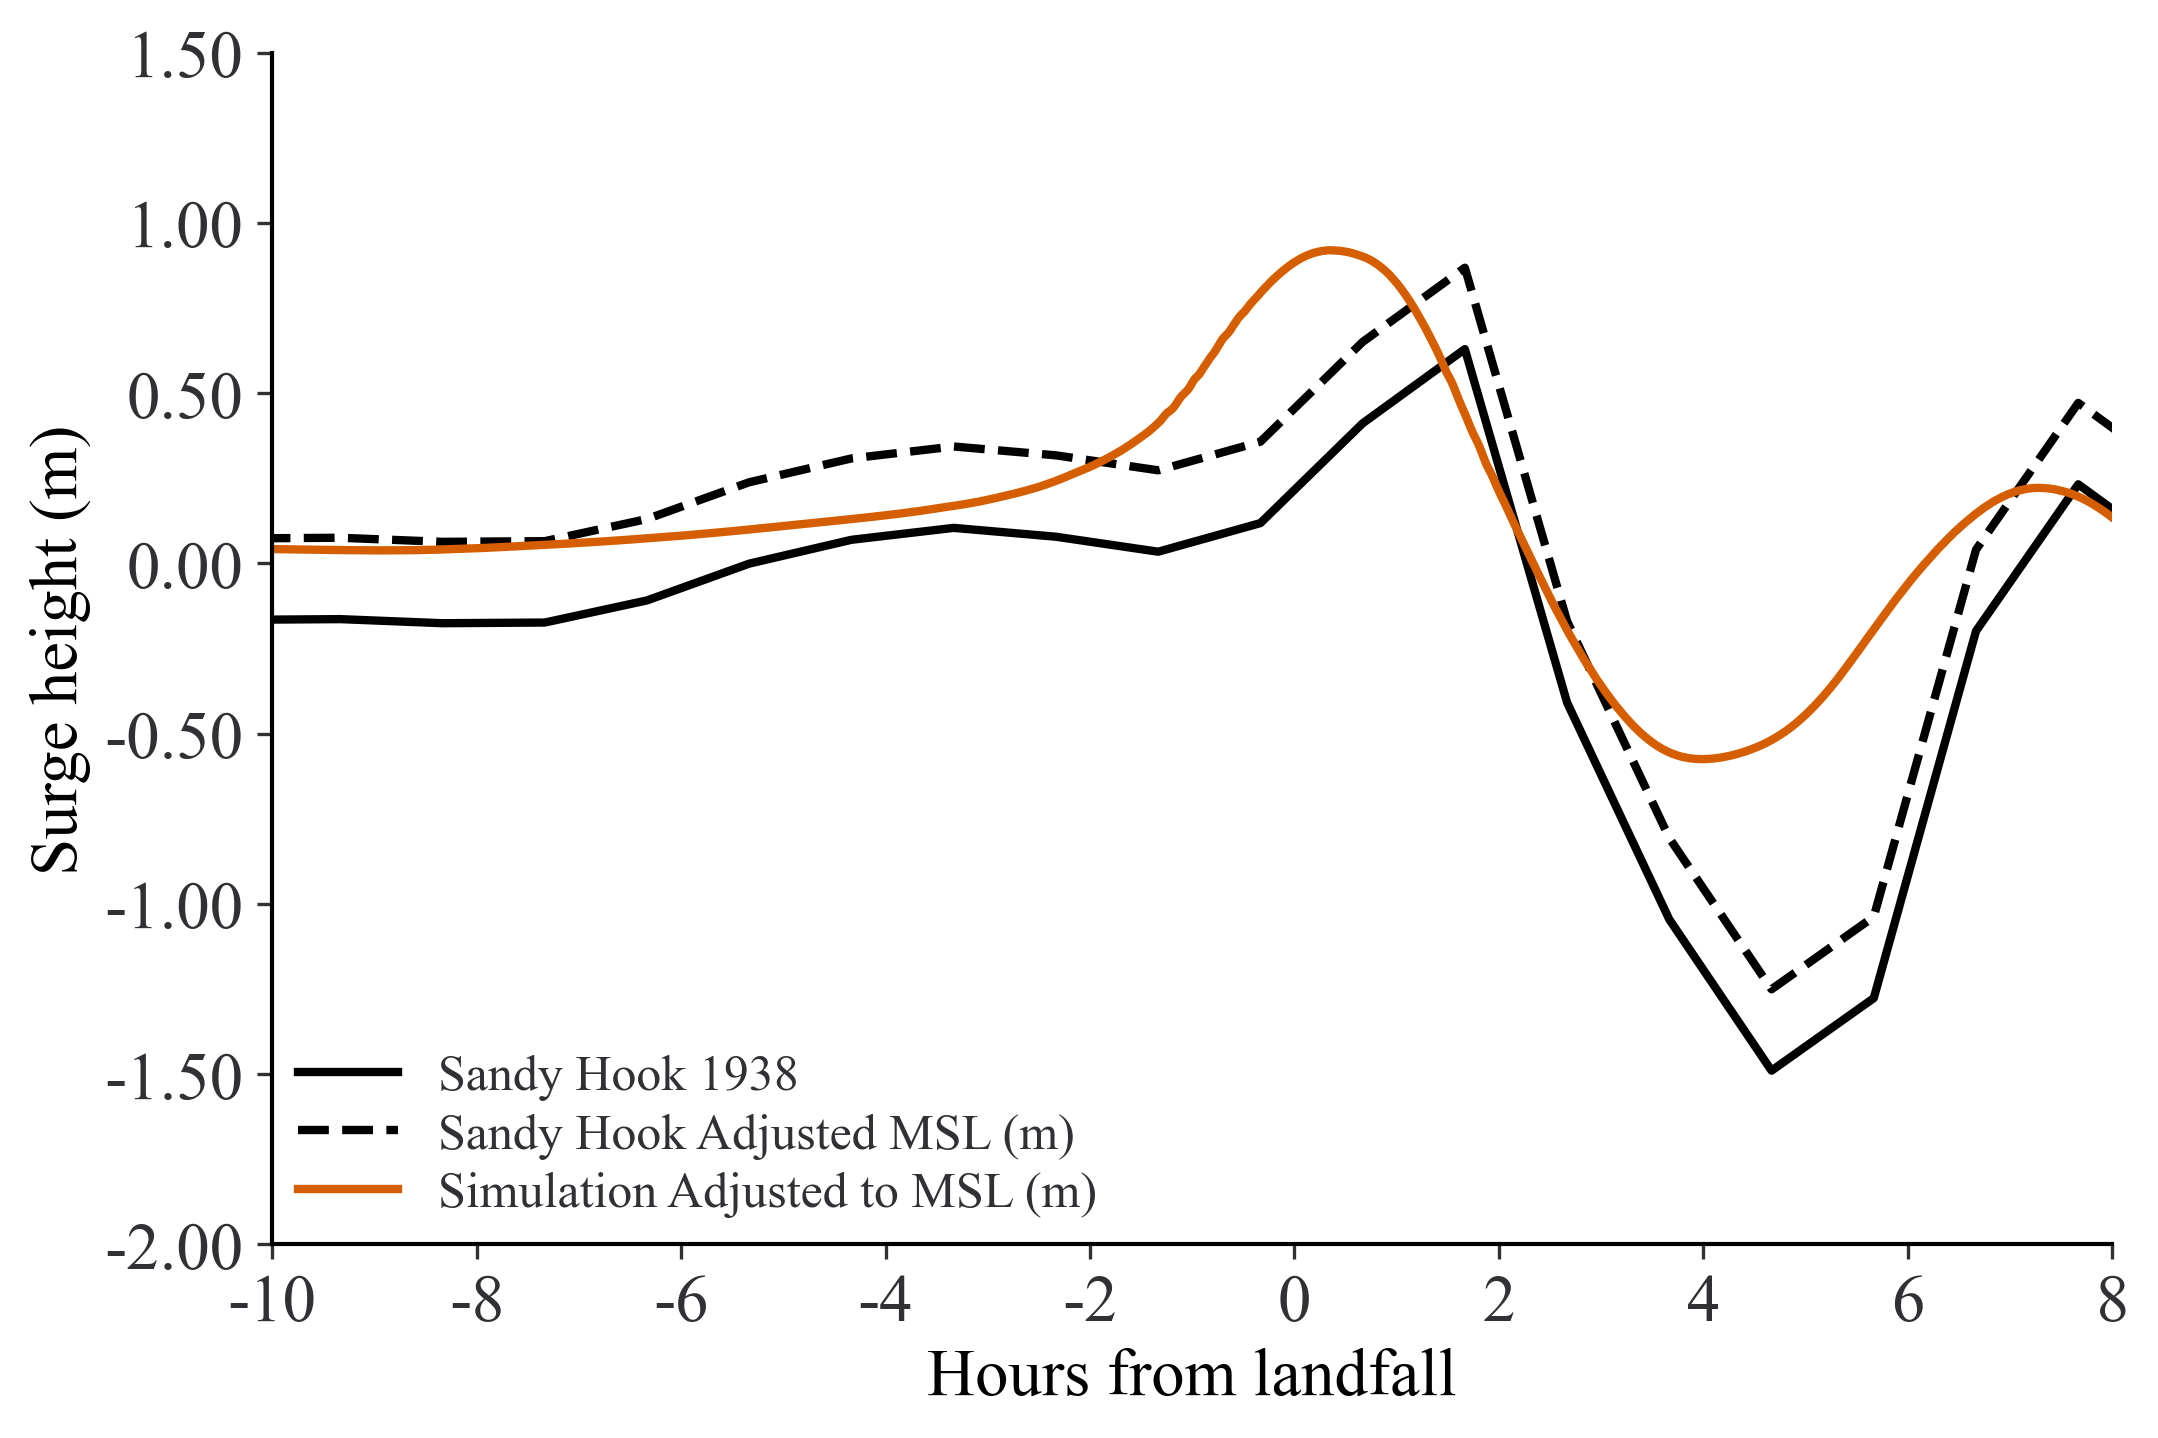

In [8]:
simple_gauge_plotting()

In [10]:
os.chdir('../../notebooks')

In [11]:
os.getcwd()

'/home/catherinej/BarrierIslandBreachProject/notebooks'